# Телеком — прогноз оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Описание полей:

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – электронный документ об оплате,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

Информация о договорах актуальна на 1 февраля 2020.

*Импортируем необходимые библиотеки:*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
RANDOM_STATE = 290822

*Загрузим данные:*

In [2]:
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet1.csv')
phone = pd.read_csv('phone.csv')

*Посмотрим на каждый датасет и изучим общую информацию:*

In [3]:
# Создадим функцию для изучения общей информации о датасетах:
def gen_info(data):
    print('Первые 5 строк датасета:')
    display(data.head(5))
    print('')
    print('Общая информация о датасете:\n')
    display(data.info())
    print('')
    print('Доля дубликатов:', data.duplicated().mean())
    print('')
    print('Доля пропущенных значений:\n')
    display(data.isna().mean())

In [4]:
gen_info(contract)

Первые 5 строк датасета:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Доля дубликатов: 0.0

Доля пропущенных значений:



customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

* В датасете **contract** находится информация о договоре клиента
* Всего в таблице 7043 строки и 8 столбцов
* Пропусков и дубликатов нет
* Столбцы BeginDate и EndDate необходимо привести к типу date
* Столбец TotalCharges привести к типу float64
* Из столбца EndDate в дальнейшем будет выделен целевой признак
* После выделения целевого признака можно создать новый признак из BeginDate и EndDate: получить продолжительность пользования услугами, а столбцы BeginDate и EndDate удалить 

In [5]:
gen_info(personal)

Первые 5 строк датасета:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Доля дубликатов: 0.0

Доля пропущенных значений:



customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

* В датасете **personal** содержатся персональные данные о клиентах
* Всего в таблице 7043 строки и 5 столбцов
* Пропусков и дубликатов нет

In [6]:
gen_info(internet)

Первые 5 строк датасета:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Доля дубликатов: 0.0

Доля пропущенных значений:



customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

* В датасете **internet** содержится информация об интернет-услугах
* Всего в таблице 5517 строк и 8 столбцов. Получается, что не все клиенты пользуются интернет-услугами, это необходимо иметь ввиду при дальнейшем объединении датасетов
* Пропусков и дубликатов нет

In [7]:
gen_info(phone)

Первые 5 строк датасета:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Общая информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Доля дубликатов: 0.0

Доля пропущенных значений:



customerID       0.0
MultipleLines    0.0
dtype: float64

* В датасете **phone** содержится информация об услугах телефонии
* Всего в таблице 6361 строка и 2 столбца. Опять же, при дальнейшем объединении датасетов необходимо иметь ввиду, что не все клиенты пользуются услугами телефонии
* Пропусков и дубликатов нет

**План работы:**

* Проведение предобработки данных: привести данные к нужным типам, объединить датасеты, обработать пропуски и т.п.
* Исследовательский анализ данных
* Подготовить данные к расчету модели: кодирование категориальных переменных, определение признаков и таргета, разделение данных на выборки
* Обучение моделей и подбор гиперпараметров
* Тестирование лучшей модели
* Написание итогового отчета 




# Предобработка данных 

Для удобства работы сразу объединим все датасеты в один (по полю customerID):

In [8]:
df = contract.merge(personal, how='left', on='customerID')\
    .merge(internet, how='left', on='customerID')\
    .merge(phone, how='left', on='customerID')

In [9]:
display(df.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [10]:
df.isna().mean()

customerID          0.000000
BeginDate           0.000000
EndDate             0.000000
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
InternetService     0.216669
OnlineSecurity      0.216669
OnlineBackup        0.216669
DeviceProtection    0.216669
TechSupport         0.216669
StreamingTV         0.216669
StreamingMovies     0.216669
MultipleLines       0.096834
dtype: float64

У нас образовались пропуски в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines. Это означает, что есть пользователи, которые пользуются только услугами телефонии или только интернет-услугами. Заменим пропуски на 'No'.

In [11]:
df.fillna('No', inplace=True)

In [12]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Прежде чем проводить дальнейшие манипуляции с данными, выделим целевой признак из столбца EndDate. 'No' означает, что это действующий клиент, если видим дату - значит клиент расторгнул договор (1 - клиент ушел, 0 - клиент остался).

In [14]:
df['Target'] = (df['EndDate'] != 'No').astype(int)

Приведем данные к необходимым типам:

In [15]:
# Заменим все значения "No" в EndDate на дату выгрузки датасета (01.02.2020)
df['EndDate'] = df['EndDate'].replace(['No'], ['2020-02-01'])

# Приведем BeginDate и EndDate в формат даты
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

# Приведем TotalCharges в числовой тип
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors ='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [16]:
# Посмотрим на пропуки в TotalCharges 
df[df['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


In [17]:
df['TotalCharges']=df['TotalCharges'].fillna(df['MonthlyCharges'])

Создадим новый столбец TotalDays с продолжительностью пользования услугами. Столбцы EndDate и BeginDate можно будет удалить позже.

In [18]:
df['Length'] = (df['EndDate'] - df['BeginDate']).dt.days

In [19]:
display(df.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,Length
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,61


*Вывод:*

Данные готовы для исследовательского анализа: получен общий датасет, в котором проведена предобработка. Данные приведены к необходимым типам, обработаны пропуски, созданы дополнительные столбцы, которые будут использоватеься для обучения моделей.

# Исследовательский анализ данных

Посмотрим распределение значений категориальных признаков:

In [20]:
categorial_columns = ['Type','PaperlessBilling','PaymentMethod','gender','SeniorCitizen',\
                       'Partner','Dependents','InternetService', 'OnlineSecurity', 'OnlineBackup',\
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

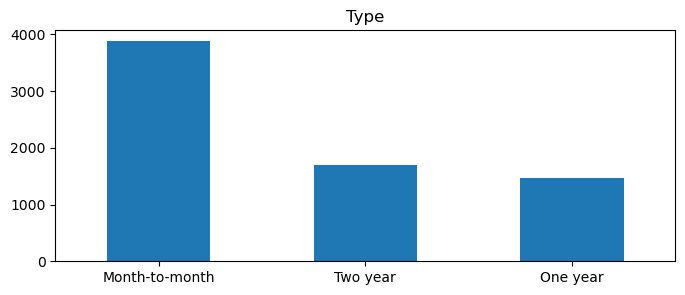

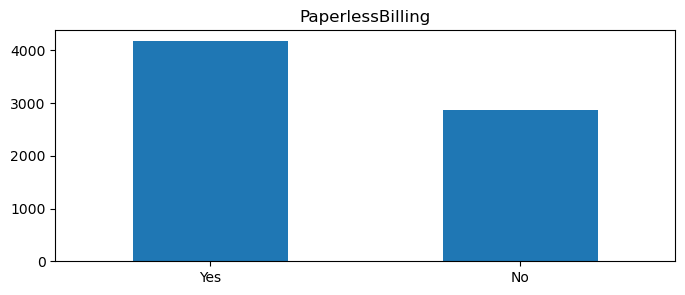

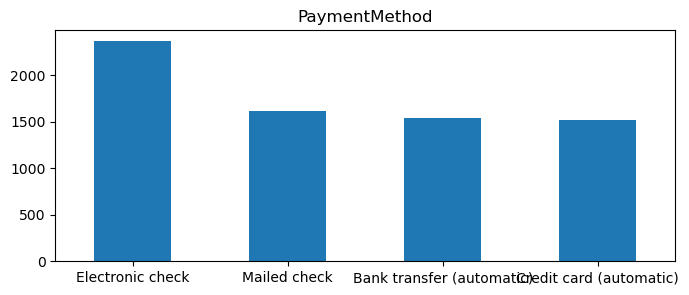

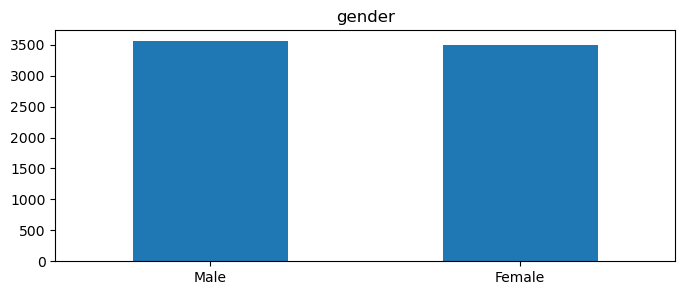

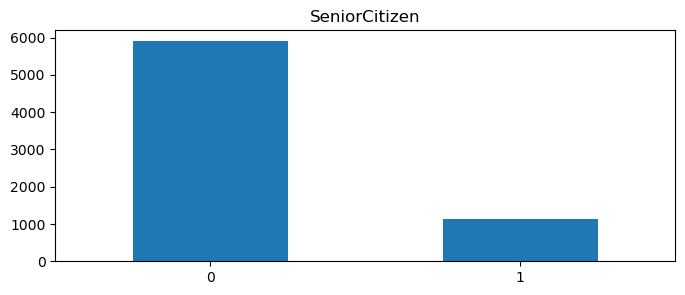

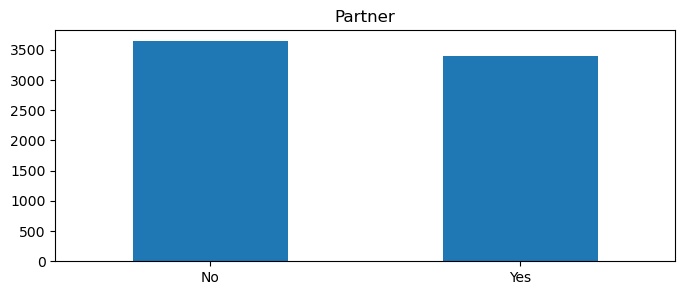

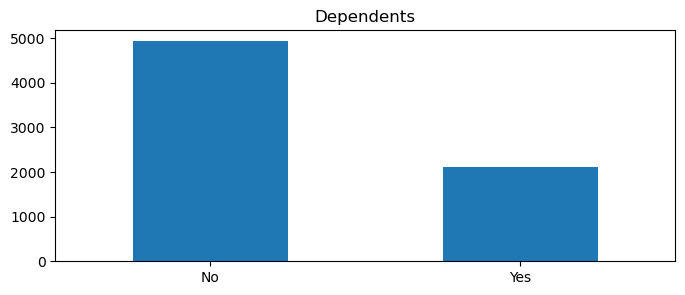

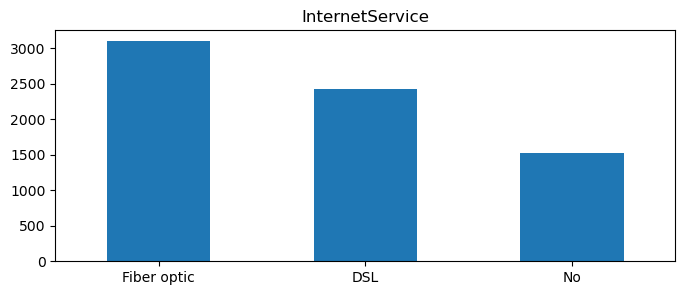

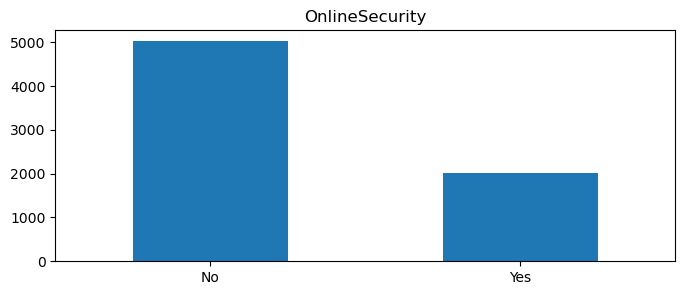

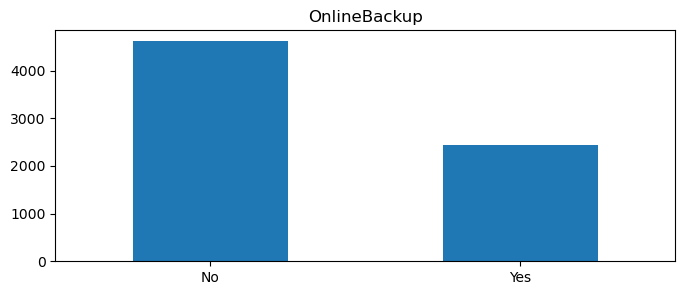

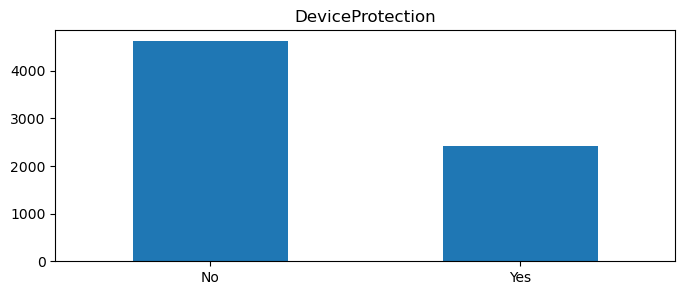

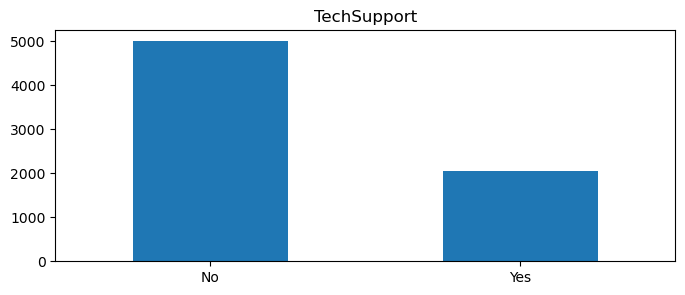

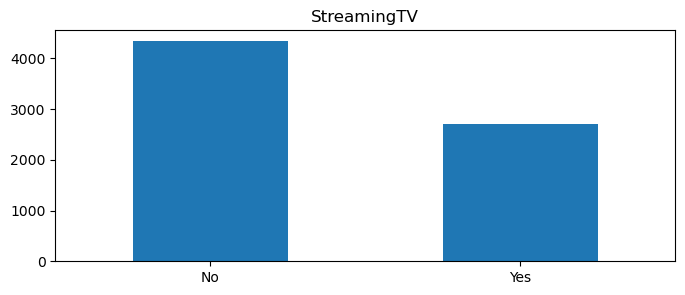

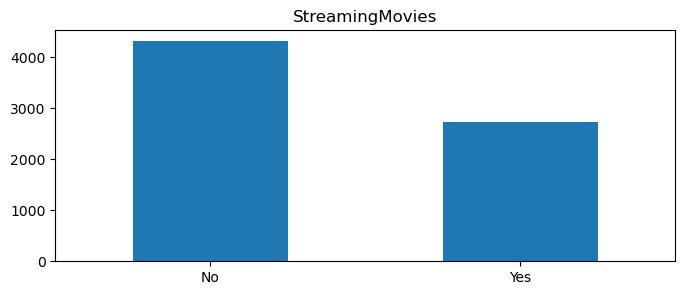

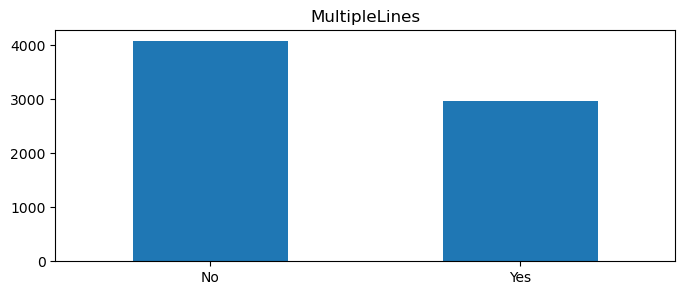

In [21]:
for i in categorial_columns:
    plt.figure(figsize=(8, 3))
    df[i].value_counts().plot(kind='bar', rot=0)
    plt.title(i)
    plt.show()

* Самый популярный способ оплаты телеком услуг - помесячно
* Большинство пользователей предпочитают документооборот в электронном виде (происходит отказ от бумажных счетов) 
* Основной способ оплаты - электронный чек. Банковский трансфер, оплату по кредитной карте и чек по почте использует меньшее количество клиентов
* В выборке присутсвует примерно одинаковое количество мужчин и женщин, в основом - экономически активное население (пенсионеров мало) 
* В выборке одинаково присутствуют люди в браке и незамужние/неженатые, примерно у трети клиентов есть иждивенцы
* Самый частый способ подключения интернета - оптоволокно
* Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines не пользуются большой популярностью у пользователей

Посмотрим на количественные данные:

In [22]:
num_columns = ['TotalCharges', 'MonthlyCharges', 'Length']

In [23]:
df[num_columns].describe()

,TotalCharges,MonthlyCharges,Length
count,7043.000000,7043.000000,7043.000000
mean,2279.798992,64.761692,985.996166
std,2266.730170,30.090047,747.587844
min,18.800000,18.250000,0.000000
25%,398.550000,35.500000,273.000000
50%,1394.550000,70.350000,883.000000
75%,3786.600000,89.850000,1676.000000
max,8684.800000,118.750000,2191.000000


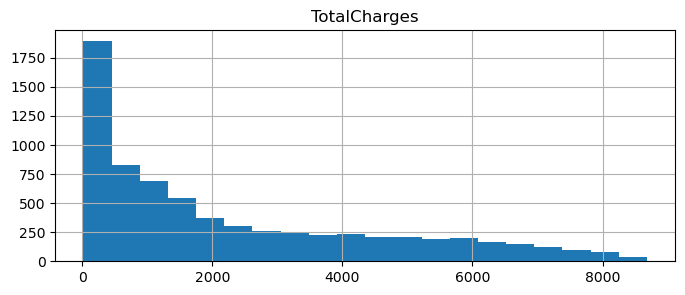

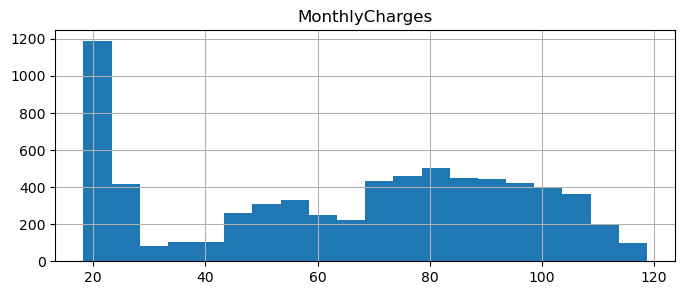

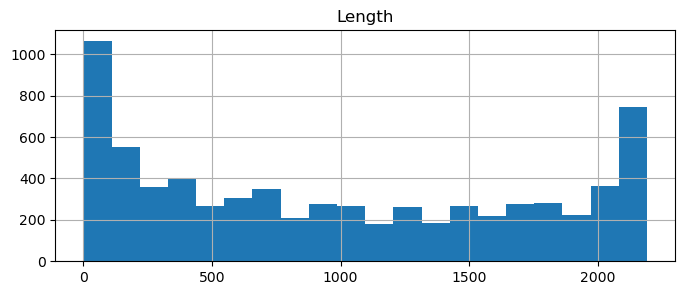

In [24]:
for i in num_columns:
    plt.figure(figsize=(8, 3))
    df[i].hist(bins=20)
    plt.title(i)
    plt.show()

* На графике MonthlyCharges, который описывает распределение ежемесячнй оплаты на услуги телекома, виден пик в районе 20$ (вероятно, это минимальный эконом тариф), а также пик в райне 80 (базовая цена за месяц)
* На графике с общей продолжительностью пользования услугами компании видно 2 пика - новые клиенты и, наоборот, клиенты, которые уже очень давно пользуются услугами

Посмотрим корреляцию между количественными признаками:

In [25]:
df[num_columns].corr()

,TotalCharges,MonthlyCharges,Length
TotalCharges,1.000000,0.651182,0.826095
MonthlyCharges,0.651182,1.000000,0.247754
Length,0.826095,0.247754,1.000000


<AxesSubplot:>

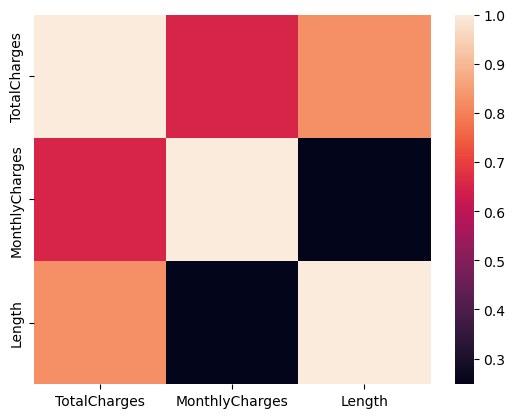

In [26]:
sns.heatmap(df[num_columns].corr())

Абсолютно очевидно, что между признаками TotalCharges и  Length наблюдается сильная корреляция (0.82). Это логично: чем дольше пользователь является клиентом компании, тем большую сумму с течением времени он заплатит. Для посмтроения моделей признак TotalCharges необходимо удалить, чтобы избежать мультиколлинеарности.

In [27]:
df = df.drop('TotalCharges', axis=1)

# Подготовка данных для расчета модели

In [28]:
# Удалим столбцы BeginDate, EndDate, а также customerID (идентификатор не является признаком при построении модели)
df = df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

In [29]:
# Определим признаки и таргет
target = df['Target'] 
features = df.drop(['Target'], axis=1)

In [30]:
# Разделим датафрейм на обучающую и тестовую выбороки 
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5634, 17)
(1409, 17)
(5634,)
(1409,)


In [31]:
# Преобразуем категориальные признаки с помощью техники OHE (One-Hot Encoding) 
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

<AxesSubplot:>

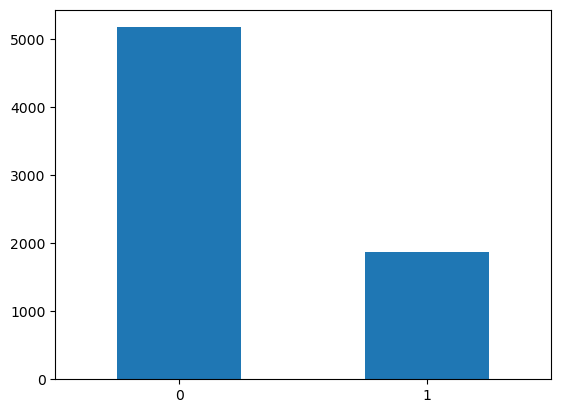

In [32]:
# Проверим баланс классов
target.value_counts().plot(kind='bar', rot=0)

Видим явный дисбаланс классов. Это необходимо иметь ввиду при построении модели.

# Обучение моделей и подбор гиперпараметров

*Модель RandomForestClassifier*

In [33]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
parameters = {
    'n_estimators': list(range(100, 1000, 100)),
    'max_depth': list(range(9, 20, 5))
}
CV_rf = GridSearchCV(estimator=rf, param_grid=parameters, n_jobs=-1, verbose=3, cv=5, scoring='roc_auc')
CV_rf.fit(features_train, target_train)
CV_rf_best_par = CV_rf.best_params_
CV_rf_best_score = CV_rf.best_score_
print(CV_rf_best_par, 'ROC_AUC=', CV_rf_best_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'max_depth': 9, 'n_estimators': 900} ROC_AUC= 0.8560230292596616


*Модель CatBoostClassifier*

In [34]:
cb = CatBoostClassifier(random_state=RANDOM_STATE)
parameters = {
    'depth': [5, 10, 20, 50, 100],
    'learning_rate': np.arange(0.01, 1, 0.2)      
}
CV_cb = GridSearchCV(estimator=cb, param_grid=parameters, n_jobs=-1, verbose=2, cv=5, scoring='roc_auc')
CV_cb.fit(features_train, target_train)
CV_cb_best_par = CV_cb.best_params_
CV_cb_best_score = CV_cb.best_score_
print(CV_cb_best_par, 'ROC_AUC=', CV_cb_best_score)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 4/5] END .....max_depth=9, n_estimators=100;, score=0.851 total time=   0.4s
[CV 2/5] END .....max_depth=9, n_estimators=300;, score=0.845 total time=   1.1s
[CV 5/5] END .....max_depth=9, n_estimators=400;, score=0.852 total time=   1.4s
[CV 3/5] END .....max_depth=9, n_estimators=600;, score=0.867 total time=   2.2s
[CV 1/5] END .....max_depth=9, n_estimators=800;, score=0.862 total time=   2.8s
[CV 4/5] END .....max_depth=9, n_estimators=900;, score=0.853 total time=   3.3s
[CV 1/5] END ....max_depth=14, n_estimators=400;, score=0.861 total time=   2.1s
[CV 4/5] END ....max_depth=14, n_estimators=500;, score=0.845 total time=   2.4s
[CV 2/5] END ....max_depth=14, n_estimators=700;, score=0.841 total time=   3.3s
[CV 5/5] END ....max_depth=14, n_estimators=800;, score=0.838 total time=   3.9s
[CV 1/5] END ....max_depth=19, n_estimators=200;, score=0.852 total time=   1.2s
[CV 5/5] END ....max_depth=19, n_estimators=200

/Users/anastasia/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
75 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anastasia/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anastasia/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/anastasia/opt/anac

0:	learn: 0.5786552	total: 57.3ms	remaining: 57.3s
1:	learn: 0.5011586	total: 59.5ms	remaining: 29.7s
2:	learn: 0.4696340	total: 61ms	remaining: 20.3s
3:	learn: 0.4415433	total: 63ms	remaining: 15.7s
4:	learn: 0.4237464	total: 65.3ms	remaining: 13s
5:	learn: 0.4126192	total: 67.7ms	remaining: 11.2s
6:	learn: 0.4048746	total: 69.7ms	remaining: 9.88s
7:	learn: 0.3995526	total: 71.7ms	remaining: 8.89s
8:	learn: 0.3942502	total: 73.5ms	remaining: 8.09s
9:	learn: 0.3898628	total: 75.7ms	remaining: 7.49s
10:	learn: 0.3859545	total: 77.9ms	remaining: 7s
11:	learn: 0.3834484	total: 80.9ms	remaining: 6.66s
12:	learn: 0.3810350	total: 84.8ms	remaining: 6.44s
13:	learn: 0.3786548	total: 88.9ms	remaining: 6.26s
14:	learn: 0.3728685	total: 91.1ms	remaining: 5.98s
15:	learn: 0.3712597	total: 94.4ms	remaining: 5.81s
16:	learn: 0.3701601	total: 96.6ms	remaining: 5.59s
17:	learn: 0.3686647	total: 99.2ms	remaining: 5.41s
18:	learn: 0.3664460	total: 102ms	remaining: 5.26s
19:	learn: 0.3659195	total: 104m

*LGBMClassifier*

In [35]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE) 
parameters = {
    'num_leaves':[20, 30, 50, 70, 100],
    'learning_rate': np.arange(0.01, 1, 0.2)
}
CV_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters, n_jobs=-1, verbose=2, cv=5, scoring='roc_auc')
CV_lgbm.fit(features_train, target_train)
CV_lgbm_best_par = CV_lgbm.best_params_
CV_lgbm_best_score = CV_lgbm.best_score_
print(CV_lgbm_best_par, 'ROC_AUC=', CV_lgbm_best_score)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'learning_rate': 0.21000000000000002, 'num_leaves': 20} ROC_AUC= 0.8990181075934975


Наилучшее значение метрики ROC_AUC показала модель CatBoostClassifier. ROC_AUC=0.91. Протестируем модель на тестовой выборке.

<AxesSubplot:>

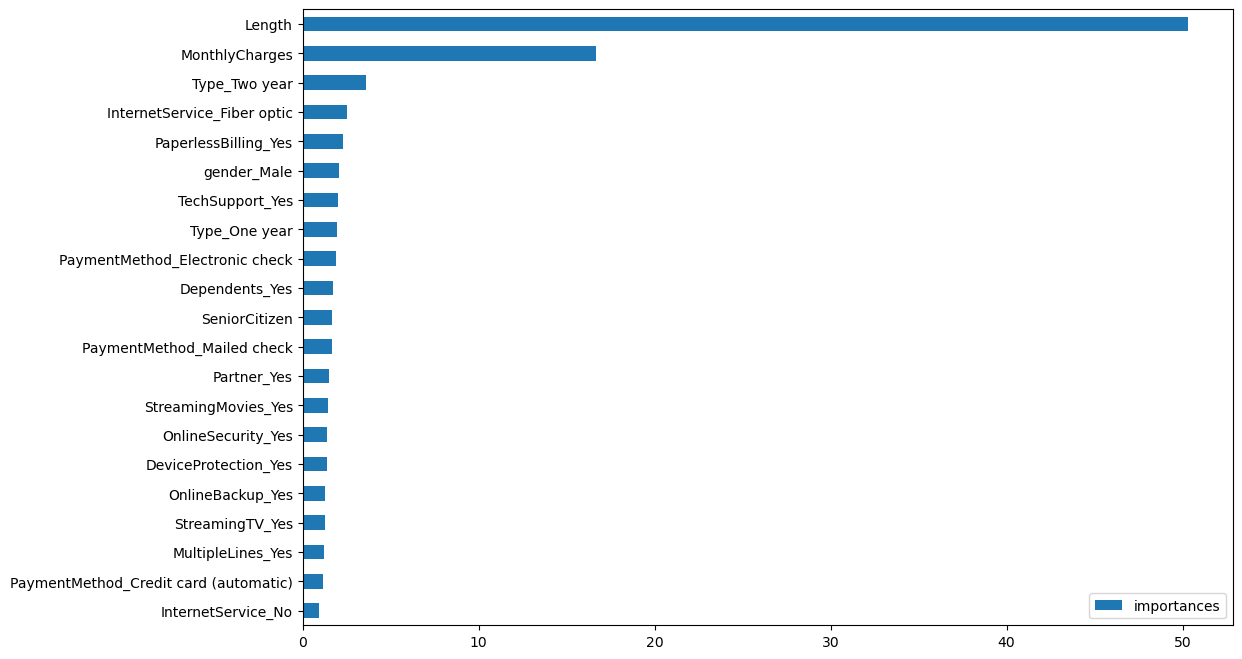

In [36]:
pd.DataFrame(CV_cb.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances']).sort_values(by='importances').plot(kind='barh', figsize=(12,8))

# Тестирование лучшей модели

In [37]:
cb = CatBoostClassifier(random_state=RANDOM_STATE, depth=5, learning_rate=0.21)
cb.fit(features_train, target_train)

0:	learn: 0.5786552	total: 2.55ms	remaining: 2.55s
1:	learn: 0.5011586	total: 4.92ms	remaining: 2.46s
2:	learn: 0.4696340	total: 6.23ms	remaining: 2.07s
3:	learn: 0.4415433	total: 11ms	remaining: 2.73s
4:	learn: 0.4237464	total: 13.1ms	remaining: 2.61s
5:	learn: 0.4126192	total: 15.5ms	remaining: 2.57s
6:	learn: 0.4048746	total: 18.1ms	remaining: 2.56s
7:	learn: 0.3995526	total: 20.4ms	remaining: 2.53s
8:	learn: 0.3942502	total: 22.5ms	remaining: 2.47s
9:	learn: 0.3898628	total: 24.1ms	remaining: 2.39s
10:	learn: 0.3859545	total: 36.8ms	remaining: 3.31s
11:	learn: 0.3834484	total: 38.6ms	remaining: 3.18s
12:	learn: 0.3810350	total: 40.5ms	remaining: 3.08s
13:	learn: 0.3786548	total: 42.7ms	remaining: 3.01s
14:	learn: 0.3728685	total: 44.3ms	remaining: 2.91s
15:	learn: 0.3712597	total: 45.8ms	remaining: 2.81s
16:	learn: 0.3701601	total: 47.6ms	remaining: 2.75s
17:	learn: 0.3686647	total: 49.6ms	remaining: 2.71s
18:	learn: 0.3664460	total: 51.6ms	remaining: 2.67s
19:	learn: 0.3659195	tot

In [38]:
cb_predictions_proba = cb.predict_proba(features_test)[:,1]
cb_predictions = cb.predict(features_test)
print('CatBoostClassifier ROC_AUC:', roc_auc_score(target_test, cb_predictions_proba))
print('CatBoostClassifier F1:', f1_score(target_test, cb_predictions))
print('CatBoostClassifier accuracy:', accuracy_score(target_test, cb_predictions))

CatBoostClassifier ROC_AUC: 0.9218521992912238
CatBoostClassifier F1: 0.7758620689655172
CatBoostClassifier accuracy: 0.8892831795599716


В данном блоке были обучены три модели: RandomForestClassifier, CatBoostClassifier и LGBMClassifier. Для подбора наилучших гиперпараметров использовался GridSearchCV. Лучшую метрику ROC_AUC на тренировочной выборке показала модель CatBoostClassifier (depth=5, learning_rate=0.21).

После тестирования модели на тестовой выбоке были достигнуты следующие значения метрик:
* **ROC AUC = 0.92**
* **F1 = 0.78**
* **Accuracy = 0.89**

# Отчёт

В ходе работы надо проектом были реализованы следующие шаги:

* В первую очередь была изучена поставленная задача (прогноз оттока клиентов оператора связи “Ниединогоразрыва.ком”) и составлен план дальнейшей работы. 

 
* В нашем распоряжении были 4 датасета с информацией о клиентах и предоставляемых услугах.


* Все датасеты были загружены и проанализированы по-отдельности. По каждому датасету был описан дальнейший план предобработки (есть ли пропуски и дубликаты, необходимость изменений типов данных).


* Далее была проведена намеченная предобработка данных:
        
        * Все датасеты были объединены в один для удобства дальнейшей работы. 
        * После объединения образовались пропуски в полях InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines. Это означает, что есть пользователи, которые пользуются только услугами телефонии или только интернет-услугами. Пропуски были заменены на ‘No’.
        * Так же появились пропуски в столбце MonthlyCharge. Скорее всего, TotalCharges не успел сформироваться на дату выгрузки, но, так как мы имеем информацию о месячном платеже,  мы понимаем, что эта сумма и будет являться TotalCharges.
        * Поля BeginDate и EndDate приведены в формат даты, поле TotalCharges - в числовой тип.
        * Был создан дополнительный признак из данных BeginDate и EndDate(продолжительность пользования услугами).
        
* Далее был проведен исследовательский анализ данных: были изучены распределения значений категориальных и количественный признаков, а также проведен анализ на мультиколлинеарность, в результате которого было принято решение удалить признак с суммарными расходами клиента на текущий момент (чтобы избежать переобучаемости модели).


* После этого данные были подготовлены для обучения моделей: удалены признаки, связанные с датой/временем и индетификатор пользователя, выделен целевой  признак. Датафрейм был разделен на обучающую и тестовую выборки в соотношении 80:20. Категориальные признаки были преобразованы с помощью техники OneHotEncoding.


* Были обучены 3 модели: RandomForestClassifier, CatBoostClassifier, LGBMClassifier.  Подбор гиперпараметров осуществлялся при помощи GridSearchCV. Наилучшее значение метрики ROC_AUC на тренировочной выборке показала модель CatBoostClassifier. ROC_AUC=0.91. Для этой модели была построена диаграмма важности признаков.


* После тестирования модели на тестовой выборке были достигнуты следующие значения метрик:
     **ROC AUC = 0.92, Accuracy = 0.89.** Необходимые значения метрик были достигнуты.


Все намеченные пункты плана были выполены. В процессе выполнения задания особых трудностей не возникло.


*Ключевые шаги в решении задачи:*


Грамотная и тщательная предобрабока данных, выделение тагрета и создание дополнительных признаков, подбор гиперпараметров с кросс-валидацией, тестирование лучшей модели.


*Итоговая модель:*


CatBoostClassifier (depth=5, learning_rate=0.21)

ROC AUC = 0.92

F1 = 0.78

Accuracy = 0.89




